In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def plot_results(images, n_cols=None):
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [19]:
(X_train_all, y_train_all), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_all = X_train_all.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_all[:-6000], X_train_all[-6000:]
y_train, y_valid = y_train_all[:-6000], y_train_all[-6000:]

4423680/4422102 [==============================] - 0s 0us/step


In [20]:
codings_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [21]:

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [22]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [23]:

batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [16]:

def train_gan(gan, dataset, batch_size, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            # Use the noise to generate fake images
            fake_images = generator(noise)
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            # Train the generator - PHASE 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            # Freeze the discriminator
            discriminator.trainable = False
            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        plot_results(fake_images, 16)                     
        plt.show()      

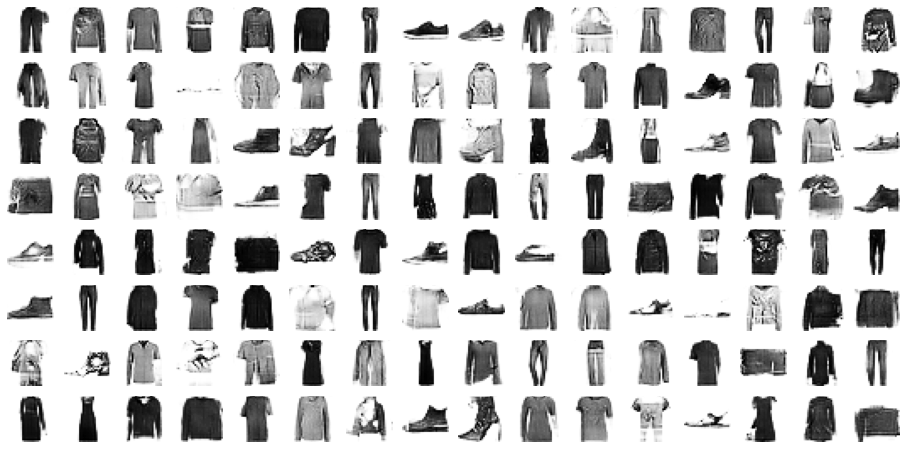

In [24]:

train_gan(gan, dataset, batch_size, codings_size, 100)